# Convolution Neural Network: CIFAR-10 Dataset

This notebook uses the classic [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is a labeled subset of the 80 million tiny images dataset. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D

## The CIFAR-10 dataset

### Get the data
CIFAR-10 dataset is provided by Keras directly. The following codes show how to load it. 

In [ ]:
# the data, shuffled and split between train and test sets 
from tensorflow.keras.datasets import cifar10
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = cifar10.load_data()

### Visualize data

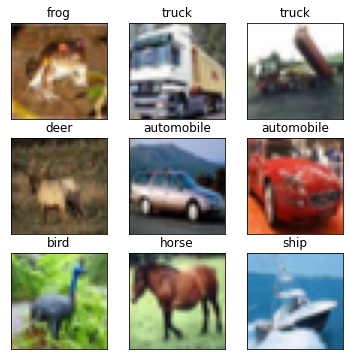

In [ ]:
label_lst = ["airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"]
fig = plt.figure(figsize=(6, 6))
col = 3
row = 3
for i in range(col*row):
    label = label_lst[y_train_pre[i][0]]
    img = X_train_pre[i,:]
    fig.add_subplot(row, col, i+1)
    plt.title('{}'.format(label))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

### convert class vectors to binary class matrices
convert class label to one-hot coding

In [ ]:
num_classes = 10 # 0-9
y_train = keras.utils.to_categorical(y_train_pre, num_classes)
y_test = keras.utils.to_categorical(y_test_pre, num_classes)
# the first 9 samples are 6, 9,9,4,1,1,2,7,8
y_train[:9,] 

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

### Normalize the features

In [ ]:
img_rows, img_cols = 32, 32
X_train = X_train_pre.astype('float32') 
X_test = X_test_pre.astype('float32')
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_test,axis=(0,1,2,3))
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)
#X_train /= 255. 
#X_test /= 255.

validation_split = 0.2
index = np.random.permutation(X_train.shape[0])
train_idx = int(X_train.shape[0]*validation_split)
X_val, X_train = X_train[index[:train_idx]], X_train[index[train_idx:]]
y_val, y_train = y_train[index[:train_idx]], y_train[index[train_idx:]]

print('training data shape:', X_train.shape)
print('{} train samples, {} validation samples, {} test samples'\
      .format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

training data shape: (40000, 32, 32, 3)
40000 train samples, 10000 validation samples, 10000 test samples


## The model

### Build the model

In [ ]:
tf.random.set_seed(14)
def build_model():
  CNN = Sequential()
  CNN.add(layers.Conv2D(32, (3,3), activation='relu',input_shape=(32,32,3)))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.Conv2D(32, (3,3),  padding='same',activation='relu'))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.MaxPooling2D(pool_size=(2,2)))
  CNN.add(layers.Dropout(0.2))

  CNN.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.Conv2D(64, (3,3),  padding='same',activation='relu'))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.MaxPooling2D(pool_size=(2,2)))
  CNN.add(layers.Dropout(0.3))

  CNN.add(layers.Conv2D(128, (3,3),  padding='same',activation='relu'))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.Conv2D(128, (3,3), activation='relu'))
  CNN.add(layers.BatchNormalization())
  CNN.add(layers.MaxPooling2D(pool_size=(2,2)))
  CNN.add(layers.Dropout(0.4))

  CNN.add(Flatten())
  CNN.add(Dense(256,activation='relu'))
  CNN.add(Dropout(0.5))
  CNN.add(Dense(10,activation='softmax'))
  return CNN

In [ ]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                      

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

### Train the model

In [ ]:
optimizer = keras.optimizers.legacy.Adam(0.0005,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        print('| Epoch {:2} | training time {:6.2f}s | train loss {:6.2f} | validation loss {:6.2f}'
              .format(epoch, t, logs['loss'], logs['val_loss']))
        
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()

EPOCHS = 100
BATCH = 64

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train, y_train, batch_size=BATCH,
                              epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val),
                              callbacks=[early_stop])

Epoch 1/100
625/625 [==============================] - 301s 480ms/step - loss: 1.9650 - accuracy: 0.3164 - val_loss: 1.5399 - val_accuracy: 0.4270
Epoch 2/100
625/625 [==============================] - 292s 467ms/step - loss: 1.4811 - accuracy: 0.4642 - val_loss: 1.2605 - val_accuracy: 0.5529
Epoch 3/100
625/625 [==============================] - 291s 465ms/step - loss: 1.2813 - accuracy: 0.5410 - val_loss: 1.2768 - val_accuracy: 0.5624
Epoch 4/100
625/625 [==============================] - 290s 464ms/step - loss: 1.1296 - accuracy: 0.5982 - val_loss: 1.0026 - val_accuracy: 0.6428
Epoch 5/100
625/625 [==============================] - 291s 465ms/step - loss: 1.0156 - accuracy: 0.6408 - val_loss: 0.8434 - val_accuracy: 0.7026
Epoch 6/100
625/625 [==============================] - 291s 466ms/step - loss: 0.9234 - accuracy: 0.6774 - val_loss: 0.8447 - val_accuracy: 0.7038
Epoch 7/100
625/625 [==============================] - 291s 466ms/step - loss: 0.8616 - accuracy: 0.7021 - val_loss: 0

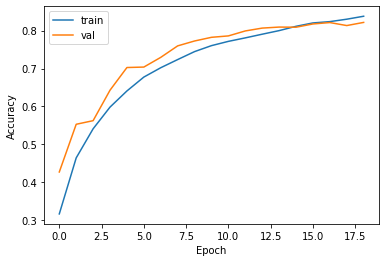

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label="train")
    plt.plot(hist['epoch'], hist['val_accuracy'], label="val")
    plt.legend()
    plt.show()

plot_history(history)

### Make predictions

Calculate the classification accuracy for testing set

In [ ]:
_, acc = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

print("Testing set accuracy: {:.2f}%".format(acc*100))

Testing set accuracy: 82.26%


Make predictions for testing data

In [ ]:
#y_pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)
y_pred[:9]

313/313 [==============================] - 16s 50ms/step


array([3, 8, 8, 0, 6, 6, 1, 4, 3])

Visualize predictions

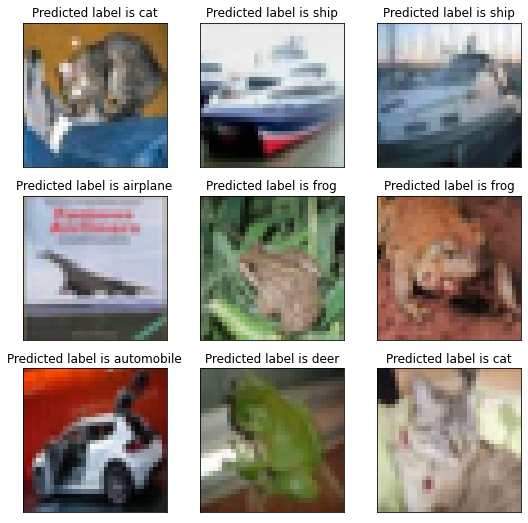

In [ ]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(col*row):
    pred = label_lst[y_pred[i]]
    img = X_test_pre[i,:]
    fig.add_subplot(row, col, i+1)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()